In [2]:
import numpy as np
import pandas as pd
import ipdb
import pprint
import sys
import matplotlib.pyplot as plt
import math
import operator
from copy import deepcopy
# from tabulate import tabulate


eps = np.finfo(float).eps
from numpy import log2 as log

# Q2

## Part-1: Logistic Regression

## Reading Data

In [3]:
def standardize_data(X):
    return (X - X.mean())/X.std()

In [4]:
data = pd.read_csv("../input_data/AdmissionDataset/data.csv")

# remove "Serial No." column
data.drop(['Serial No.'], axis = 1, inplace = True)

# removing last two columns as their values are in the range [0, 1]
data_std = standardize_data(data.iloc[:, :-2])
data_std[["Research", "Chance of Admit"]] = data[["Research", "Chance of Admit"]]

# msk = np.random.rand(len(data)) < 0.8
# train = X_std[msk].reset_index (drop=True)
# validate = X_std[~msk].reset_index (drop=True)

# Selecting first 80% as Training Data and remaining as Validation Data
train, validate = np.split(data_std, [int(.8*len(data_std))])
validate = validate.reset_index(drop=True)

In [5]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

In [7]:
y_train.shape

(360,)

In [56]:
class LogisticRegression:
    def __init__(self, learning_rate = 0.01, max_iterations = 1000):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations

    def intercept_add(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        X = self.intercept_add(X)

        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.max_iterations):
            z = np.dot(X, self.theta)   # dot product
            h = self.sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= (self.learning_rate * gradient)
    
    def predict(self, X, threshold):
        X = self.intercept_add(X)
        predicted_prob = self.sigmoid(np.dot(X, self.theta))
        return predicted_prob >= threshold

In [178]:
model = LogisticRegression(0.01, 10000)
model.fit(X_train, y_train)

In [58]:
X_validate = validate.iloc[:, :-1]
y_validate = validate.iloc[:, -1]

In [177]:
thresholds = []
for t in range(1, 10):
    thresholds.append(t/10)

In [156]:
def logistic_reg_performance_get(threshold_list):
    accuracy_list = []
    recall_list = []
    precision_list = []
    
    for threshold in threshold_list:  
        correct = 0
        actual_class = (y_validate >= threshold)
        predicted_class = model.predict(X_validate, threshold)

        actual_label_series = pd.Series(actual_class, name='Ground Truth')
        prediction_label_series = pd.Series(predicted_class, name='Predicted Label')
        confusion_df = pd.crosstab(actual_label_series, prediction_label_series, margins=True)
#         print(tabulate(confusion_df, headers='keys', tablefmt='psql'))
     
        label_names = confusion_df.keys()[:-1]
        precision = {}
        recall = {}
        f1_score = {}
        for label in label_names:
            correct += confusion_df[label][label]
            _precision = float(confusion_df[label][label]) / confusion_df['All'][label]
            precision[label] = round(_precision * 100, 2)
            _recall = float(confusion_df[label][label]) / confusion_df[label]['All']
            recall[label] = round(_recall * 100, 2)

            if _recall == 0.0:
                _recall = eps
            if _precision == 0.0:
                _precision = eps

            f1_score[label] = round((2 / ((1/_recall) + (1/_precision))), 2)

        accuracy = round((float(correct) / confusion_df['All']['All']) * 100, 2)
        accuracy_list.append(accuracy)
        precision_list.append(precision[True])
        recall_list.append(recall[True])

    return accuracy_list, precision_list, recall_list

In [175]:
logistic_reg_accuracies, logistic_reg_precision, logistic_reg_recall = logistic_reg_performance_get(thresholds)

## Part-3: Recall and Precision vs Threshold value

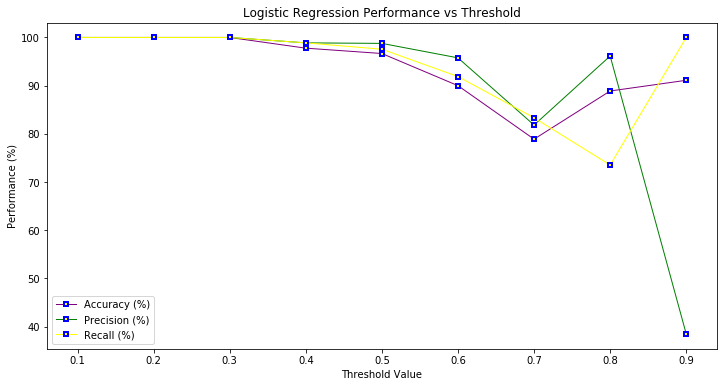

In [176]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(thresholds, logistic_reg_accuracies, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Accuracy (%)');
ax.plot(thresholds, logistic_reg_precision, color="green", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Precision (%)');
ax.plot(thresholds, logistic_reg_recall, color="yellow", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Recall (%)');

plt.title("Logistic Regression Performance vs Threshold")
plt.ylabel("Performance (%)")
plt.xlabel("Threshold Value")
plt.legend()
plt.show()

### Receiver Operating Characteristic (ROC) curve. 
* The ROC curve shows how the recall vs precision relationship changes as we vary the threshold for identifying a positive in our model. The threshold represents the value above which a data point is considered in the positive class. If we have a model for identifying a disease, our model might output a score for each patient between 0 and 1 and we can set a threshold in this range for labeling a patient as having the disease (a positive label). By altering the threshold, we can try to achieve the right precision vs recall balance.

* An ROC curve plots the true positive rate on the y-axis versus the false positive rate on the x-axis. The true positive rate (TPR) is the recall and the false positive rate (FPR) is the probability of a false alarm. Both of these can be calculated from the confusion matrix.

## Part-2: k-NN

In [167]:
def knn_data_get(d, threshold):
    data_knn = d.iloc[:, :-1]
    y_knn = d.iloc[:,-1] >= threshold
    data_knn["Chance of Admit"] = y_knn
    
    train_knn, validate_knn = np.split(data_knn, [int(.8*len(data_knn))])
    validate_knn = validate_knn.reset_index(drop=True)

    return train_knn, validate_knn

In [168]:
distances_list = []

def distances_get(test_sample, training_data, distance_measure):
    distances = []
    p = 1
    if distance_measure == "Euclidean":
        p = 2
    elif distance_measure == "Minkowski":
        p = 5

    for index, row in training_data.iterrows():
        dist = 0
        for i in range(0, 7):
            d = abs(test_sample[i] - row[i])
            dist += pow(d, p)
        distances.append(((dist ** (1./p)), row[-1]))

    distances = sorted(distances, key = operator.itemgetter(0))
    distances_list.append(distances)

In [169]:
def kNN_validation(distances_list, validation_data, k):
    TP = 0; FP = 0; TN = 0; FN = 0;

    for index, validation_sample in validation_data.iterrows():
        distances = distances_list[index]

        nTrue = 0
        for i in range(k):
            if distances[i][1] == True:
                nTrue += 1
        nFalse = k - nTrue

        if nTrue > nFalse:
            prediction = True
        else:
            prediction = False

        if prediction == True:
            if validation_sample[-1] == True:
                TP += 1
            else:
                FP += 1
        else:
            if validation_sample[-1] == False:
                TN += 1
            else:
                FN += 1

    accuracy = float(TP + TN) / (TP + FP + TN + FN)
    if TP == 0:
        recall = 0.0
        precision = 0.0
        f1_score = 2 / ((1/(eps)) + (1/(eps)))
    else:
        recall = float(TP) / (TP + FN)
        precision = float(TP) / (TP + FP)
        f1_score = 2 / ((1/(recall)) + (1/(precision)))

    return (round(accuracy * 100, 2), round(recall * 100, 2), round(precision * 100, 2), round(f1_score, 2))

In [170]:
def knn_performance_get(distance_measure, train_knn, validate_knn):
    global distances_list
    distances_list = []

    for index, validation_sample in validate_knn.iterrows():
        distances_get(validation_sample, train_knn, distance_measure)

    performance = pd.DataFrame(columns=['K', 'accuracy (%)', 'recall (%)', 'precision (%)', 'f1_score'])

    for k in range(1, 16, 2):
        accuracy, recall, precision, f1_score = kNN_validation(distances_list, validate_knn, k)
        performance = performance.append(pd.DataFrame([[k, accuracy, recall, precision, f1_score]], columns=['K', 'accuracy (%)', 'recall (%)', 'precision (%)', 'f1_score']), ignore_index=True)
    
    return performance

In [171]:
def knn_accuracies_get():
    knn_accuracies = []
    for threshold in thresholds:
        train_knn, validate_knn = knn_data_get(data, threshold)
        knn_max_performance = knn_performance_get("Euclidean", train_knn, validate_knn).max()
        max_accuracy = knn_max_performance["accuracy (%)"]
        knn_accuracies.append(max_accuracy)
    
    return knn_accuracies

In [172]:
knn_accuracies = knn_accuracies_get()

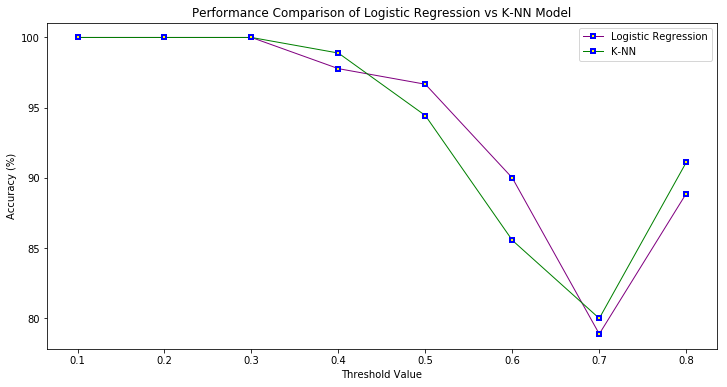

In [173]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(thresholds, logistic_reg_accuracies, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='Logistic Regression');
ax.plot(thresholds, knn_accuracies, color="green", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue", label='K-NN');

plt.title("Performance Comparison of Logistic Regression vs K-NN Model")
plt.ylabel("Accuracy (%)")
plt.xlabel("Threshold Value")
plt.legend()
plt.show()